## Import necessary libraries

In [1]:
from __future__ import print_function
import keras
from khaled_utils import plot_history, TimeHistory
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import time

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Build the model

In [2]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dro

## Time Callback

In [3]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
    
time_callback = TimeHistory()

## History Callback

#### It's the same object returned by: `history = model.fit(...)`

In [4]:
from keras.callbacks import History
history = History()

## ModelCheckpoint Callback

In [5]:
from keras.callbacks import ModelCheckpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

## TensorBoard Callback
### To run TensorBorad, run:
#### `$ tensorboard --logdir=/root/ipython/logs/`
#### `$ docker exec -it khaled_container tensorboard --logdir=/root/ipython/logs/ --port=16006`

In [6]:
from keras.callbacks import TensorBoard
from time import strftime
tensorboard = TensorBoard(log_dir="logs/{}".format(strftime('%Y_%m_%d_%H_%M_%S')))

## Limit GPU usage

In [7]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
set_session(tf.Session(config=config))

## Train the model

In [8]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[time_callback,checkpoint,tensorboard, history])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 8s 132us/step - loss: 0.3075 - acc: 0.9031 - val_loss: 0.0537 - val_acc: 0.9828

Epoch 00001: val_acc improved from -inf to 0.98280, saving model to weights-improvement-01-0.98.hdf5
Epoch 2/12
60000/60000 [==============================] - 6s 97us/step - loss: 0.0962 - acc: 0.9715 - val_loss: 0.0390 - val_acc: 0.9864

Epoch 00002: val_acc improved from 0.98280 to 0.98640, saving model to weights-improvement-02-0.99.hdf5
Epoch 3/12
60000/60000 [==============================] - 6s 99us/step - loss: 0.0723 - acc: 0.9779 - val_loss: 0.0315 - val_acc: 0.9880

Epoch 00003: val_acc improved from 0.98640 to 0.98800, saving model to weights-improvement-03-0.99.hdf5
Epoch 4/12
60000/60000 [==============================] - 6s 98us/step - loss: 0.0620 - acc: 0.9812 - val_loss: 0.0261 - val_acc: 0.9919

Epoch 00004: val_acc improved from 0.98800 to 0.99190, saving model to weights-improveme

In [9]:
print("Test loss: {0:.4f} \tTest accuracy: {1:.2f}% \tTime elpased: {2:.2f} seconds".format(
    history.history['val_loss'][-1],
    history.history['val_acc'][-1]*100,
    np.sum(time_callback.times)))

Test loss: 0.0168 	Test accuracy: 99.45% 	Time elpased: 73.55 seconds


## Plot Model

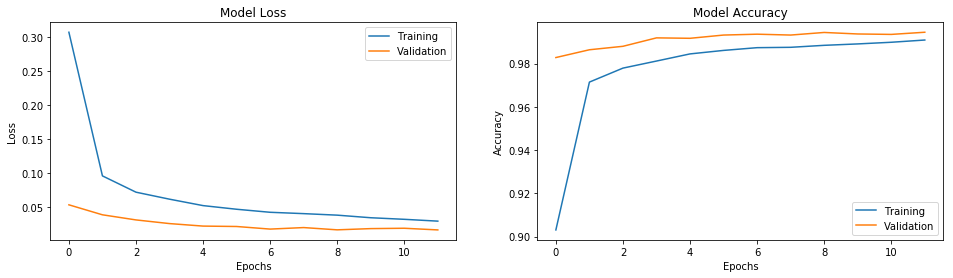

Test loss: 0.0168 	Test accuracy: 99.45%


In [10]:
def plot_history(history):
	plt.figure(figsize=(16,4))

	plt.subplot(1, 2, 1)
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title('Model Loss')
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.legend(['Training', 'Validation'], loc='upper right')

	plt.subplot(1, 2, 2)
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.title('Model Accuracy')
	plt.plot(history.history['acc'])
	plt.plot(history.history['val_acc'])
	plt.legend(['Training', 'Validation'], loc='lower right')

	plt.show()
      
	validation_accuracy = history.history['val_acc'][-1]
	validation_loss = history.history['val_loss'][-1]   
	print("Test loss: {0:.4f} \tTest accuracy: {1:.2f}%".format(validation_loss,validation_accuracy*100))

plot_history(history)

## Load the model from file
### The model should be built and compiled before loading the weights from file

In [11]:
import os
filename = 'weights-improvement-12-0.99.hdf5'
if os.path.isfile(filename):
    model.load_weights(filename)
    print ("The model has been loaded")
else:
    print ("%s does not exist"%filename)

The model has been loaded


## Delete model & Clear session

In [12]:
# del model
# K.clear_session()